## In statistics, the variance inflation factor (VIF) is the ratio (quotient) of the variance of estimating some parameter in a model that includes multiple other terms (parameters) by the variance of a model constructed using only one term.

### I used this VIF method and found some over correlated columns and dropped 'year' and 'is_quarter_date'.

### After dropping these 2 columns VIF value for all other columns stayed below 5 so I took all of them into consideration and splitted the data

### After that I transformed the cyclical features like 'hour', 'month' & 'day_of_week' using cosine and sine transformation.

### Then modelling and training the data.

#### Somehow I was trying to convert target variable using logarithmic transformation, cosine transformation & used as it was but got some good results.

#### After predicting the test data demand variable I added 'z back because in labelencoder it reduced '1' from each values.

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
ss = pd.read_csv("sample_submission.csv")

In [8]:
z = (train['demand'].count() - train['demand'].mean()) / train['demand'].std()
z

436.0232680395623

In [9]:
df = train.copy()

In [10]:
 # Extract date feature
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda x: x.year) #because model wont have experience past 2017 cause year has (2015-2017)
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
df['is_quarter_date'] = df['date'].apply(lambda x: x.quarter)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x>4 else 0)

df.drop(['date'], axis=1, inplace=True)

In [11]:
# Extract date feature for test
test['date'] = pd.to_datetime(test['date'])
# test['year'] = test['date'].apply(lambda x: x.year) #because model wont have experience past 2017 cause year has (2015-2017)
test['month'] = test['date'].apply(lambda x: x.month)
test['day'] = test['date'].apply(lambda x: x.day)
test['day_of_week'] = test['date'].apply(lambda x: x.dayofweek)
# test['is_quarter_date'] = test['date'].apply(lambda x: x.quarter)
test['is_weekend'] = test['day_of_week'].apply(lambda x: 1 if x>4 else 0)

test.drop(['date'], axis=1, inplace=True)

In [12]:
#creating function to identify time of day: morning, afternoon, evening, night, etc.
def time_of_day(n):
    if n in range(4,8):
        return 'Early Morning'
    elif n in range(8,12):
        return 'Morning'
    elif n in range(12,18):
        return 'Afternoon'
    elif n in range(18,21):
        return 'Evening'
    elif n in range(21,25) or n==0:
        return 'Night'
    elif n in range(1,4):
        return 'Late Night'
    
df['Type_of_Day'] = df['hour'].apply(lambda x: time_of_day(x))

In [13]:
test['Type_of_Day'] = test['hour'].apply(lambda x: time_of_day(x))

In [14]:
def month2seasons(x):
    if x in [9, 10, 11]:
        season = 'Spring'
    elif x in [12, 1, 2]:
        season = 'Summer'
    elif x in [3, 4, 5]:
        season = 'Autumn'
    elif x in [6, 7, 8]:
        season = 'Winter'
    return season

df['Season'] = df['month'].apply(month2seasons)

In [15]:
test['Season'] = test['month'].apply(month2seasons)

In [16]:
df['Type_of_Day'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
df['Season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

In [17]:
test['Type_of_Day'].replace({'Afternoon': 0, 'Morning' : 1, 'Night':2, 'Evening':3, 'Early Morning':4, 'Late Night':5}, 
                          inplace=True)
test['Season'].replace({'Spring':0, 'Summer':1, 'Autumn':2, 'Winter':3}, inplace=True)

<AxesSubplot:xlabel='hour', ylabel='demand'>

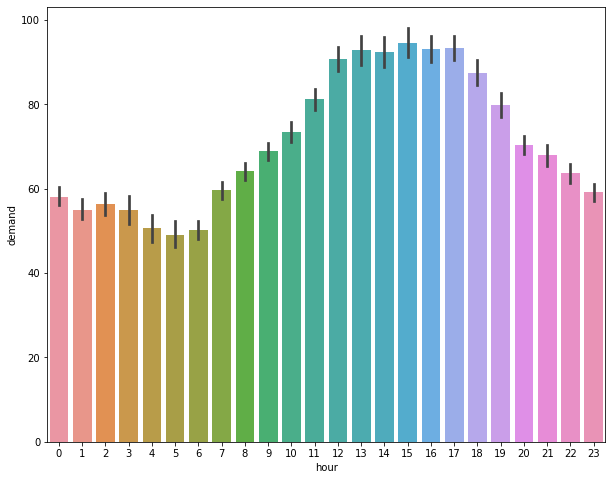

In [18]:
plt.figure(figsize=(10,8))
sns.barplot(x=df['hour'], y=df['demand'])

In [19]:
#split df into X & y
y = df['demand'].copy()
X = df.drop('demand', axis=1).copy()

In [20]:
# Feature engineering of hour of month like cyclical feature & days in week feature
X['hour_sin'] = np.sin(X['hour']*(2.*np.pi/24))
X['hour_cos'] = np.cos(X['hour']*(2.*np.pi/24))
X['month_sin'] = np.sin((X['month']-1)*(2.*np.pi/12))
X['month_cos'] = np.cos((X['month']-1)*(2.*np.pi/12))

X['day_of_week'] = np.cos(X['day_of_week'])

X.drop(['hour', 'month'], axis=1, inplace=True)

In [21]:
# Feature engineering of hour of month like cyclical feature & days in week feature
test['hour_sin'] = np.sin(test['hour']*(2.*np.pi/24))
test['hour_cos'] = np.cos(test['hour']*(2.*np.pi/24))
test['month_sin'] = np.sin((test['month']-1)*(2.*np.pi/12))
test['month_cos'] = np.cos((test['month']-1)*(2.*np.pi/12))

test['day_of_week'] = np.cos(test['day_of_week'])

test.drop(['hour', 'month'], axis=1, inplace=True)

In [22]:
X

,year,day,day_of_week,is_quarter_date,is_weekend,Type_of_Day,Season,hour_sin,hour_cos,month_sin,month_cos
0,2018,18,0.283662,3,1,1,3,0.707107,-0.707107,-0.5,-0.866025
1,2018,18,0.283662,3,1,1,3,0.500000,-0.866025,-0.5,-0.866025
2,2018,18,0.283662,3,1,0,3,-0.258819,-0.965926,-0.5,-0.866025
3,2018,18,0.283662,3,1,0,3,-0.500000,-0.866025,-0.5,-0.866025
4,2018,18,0.283662,3,1,0,3,-0.707107,-0.707107,-0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...
18242,2021,28,0.960170,1,1,3,1,-0.965926,0.258819,0.5,0.866025
18243,2021,28,0.960170,1,1,3,1,-0.866025,0.500000,0.5,0.866025
18244,2021,28,0.960170,1,1,2,1,-0.707107,0.707107,0.5,0.866025
18245,2021,28,0.960170,1,1,2,1,-0.500000,0.866025,0.5,0.866025


In [23]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Columns'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Columns
0,28.428392,year
3,17.245147,is_quarter_date
6,7.561064,Season
5,6.543576,Type_of_Day
1,4.246286,day
9,4.017243,month_sin
8,2.621548,hour_cos
10,2.144093,month_cos
4,1.768265,is_weekend
7,1.561065,hour_sin


In [24]:
X.drop(['year', 'is_quarter_date'], axis=1, inplace=True)

In [25]:
vif_info_afterdrop = pd.DataFrame()
vif_info_afterdrop['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info_afterdrop['Columns'] = X.columns
vif_info_afterdrop.sort_values('VIF', ascending=False)

,VIF,Columns
4,4.944764,Season
3,4.397171,Type_of_Day
0,3.388727,day
6,2.023782,hour_cos
7,1.747674,month_sin
2,1.715188,is_weekend
8,1.591735,month_cos
5,1.351519,hour_sin
1,1.275900,day_of_week


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.linear_model import Lasso, LinearRegression
from lightgbm import LGBMRegressor

In [27]:
X.values

array([[18.        ,  0.28366219,  1.        , ..., -0.70710678,
        -0.5       , -0.8660254 ],
       [18.        ,  0.28366219,  1.        , ..., -0.8660254 ,
        -0.5       , -0.8660254 ],
       [18.        ,  0.28366219,  1.        , ..., -0.96592583,
        -0.5       , -0.8660254 ],
       ...,
       [28.        ,  0.96017029,  1.        , ...,  0.70710678,
         0.5       ,  0.8660254 ],
       [28.        ,  0.96017029,  1.        , ...,  0.8660254 ,
         0.5       ,  0.8660254 ],
       [28.        ,  0.96017029,  1.        , ...,  0.96592583,
         0.5       ,  0.8660254 ]])

In [28]:
y = y - z
y

0       -345.023268
1       -415.023268
2       -413.023268
3       -332.023268
4       -355.023268
            ...    
18242   -341.023268
18243   -348.023268
18244   -397.023268
18245   -332.023268
18246   -351.023268
Name: demand, Length: 18247, dtype: float64

In [92]:
le = LabelEncoder()
encoded_y = le.fit_transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, train_size=0.7, random_state=42)

In [30]:
models = {
    'Linear Regression(Ridge)' : Ridge(),
    '          Neural Network' : MLPRegressor(),
    '           Random Forest' : RandomForestRegressor(),
    '                Catboost' : CatBoostRegressor(verbose=0),
    '       XGBoost Regressor' : XGBRegressor(),
    '    XGBoost RF Regressor' : XGBRFRegressor(),
    'Linear Regression(lasso)' : Lasso(),
    '       Linear Regression' : LinearRegression(),
    ' Light Gradient Boosting' : LGBMRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + ' trained.')

Linear Regression(Ridge) trained.


C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


          Neural Network trained.
           Random Forest trained.
                Catboost trained.
       XGBoost Regressor trained.
    XGBoost RF Regressor trained.
Linear Regression(lasso) trained.
       Linear Regression trained.
 Light Gradient Boosting trained.


In [31]:
def get_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    return rmse

def get_r2(y_test, y_pred):
    r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - y_test.mean())**2))
    return r2

In [32]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = get_rmse(y_test, y_pred)
    print(name + ' RMSE: {:.2f}'.format(rmse))

Linear Regression(Ridge) RMSE: 37.84
          Neural Network RMSE: 36.63
           Random Forest RMSE: 34.83
                Catboost RMSE: 33.39
       XGBoost Regressor RMSE: 34.06
    XGBoost RF Regressor RMSE: 35.08
Linear Regression(lasso) RMSE: 38.08
       Linear Regression RMSE: 37.84
 Light Gradient Boosting RMSE: 33.07


In [33]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = get_r2(y_test, y_pred)
    print(name + ' R^2: {:.5f}'.format(r2))

Linear Regression(Ridge) R^2: 0.15490
          Neural Network R^2: 0.20813
           Random Forest R^2: 0.28400
                Catboost R^2: 0.34180
       XGBoost Regressor R^2: 0.31532
    XGBoost RF Regressor R^2: 0.27373
Linear Regression(lasso) R^2: 0.14433
       Linear Regression R^2: 0.15490
 Light Gradient Boosting R^2: 0.35444


In [34]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
mse(y_test, lgbm_pred, squared=False)

33.071859283336416

In [35]:
get_r2(y_test, lgbm_pred)

0.35443612939446156

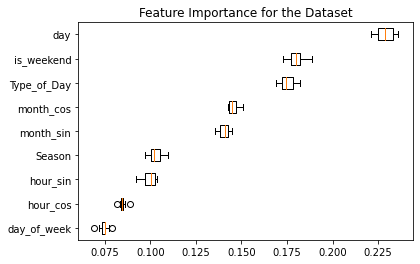

In [37]:
from sklearn.inspection import permutation_importance

result = permutation_importance(lgbm, X.values, y, n_repeats=10, random_state=42)

perm_imp_idx = result.importances_mean.argsort()

plt.boxplot(result.importances[perm_imp_idx].T, vert=False, labels=X.columns[perm_imp_idx])
plt.title('Feature Importance for the Dataset')

plt.show()

In [38]:
predicted_test = lgbm.predict(test.values)
predicted_test

array([-372.45039978, -386.64963483, -388.8511775 , ..., -371.20300143,
       -374.7065956 , -374.64963242])

## Here we add 'z' because I subtracted with 'z - score' of target 
## SO here I added 'z' and got the predicted test

In [39]:
final_test = predicted_test + z
final_test

array([63.57286826, 49.37363321, 47.17209054, ..., 64.82026661,
       61.31667244, 61.37363562])

In [40]:
ss['demand'] = final_test

In [41]:
ss['demand']

0       63.572868
1       49.373633
2       47.172091
3       50.069266
4       49.741772
          ...    
7645    88.144515
7646    79.034646
7647    64.820267
7648    61.316672
7649    61.373636
Name: demand, Length: 7650, dtype: float64

In [42]:
ss.to_csv('ss2.csv', index=False)